In [63]:
import pickle
import numpy as np
import torch
from torch.autograd import Variable as V
import torchvision.transforms as transforms
from torch.nn import functional as F
from PIL import Image
from PIL.ImageFilter import GaussianBlur
from genre_classifier import GenreClassifier
topil = transforms.ToPILImage()

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
preds = pickle.load(open('results/test_preds_3bn.p', 'rb')).data
labels = pickle.load(open('results/test_labels_3bn.p', 'rb')).data
ids = pickle.load(open('results/test_ids_3bn.p', 'rb'))

In [75]:
rand_preds = preds.clone()
for genre_ind in range(preds.size(1)):
    genre_labs = labels[:,genre_ind].clone().numpy()
    np.random.shuffle(genre_labs)
    rand_preds[:,genre_ind] = torch.FloatTensor(genre_labs)

bce = torch.nn.BCELoss()
rand_test_loss = bce(V(rand_preds), V(labels))
print(rand_test_loss.data[0])

4.4035234451293945


In [99]:
genre_ids = {'Action': 0,
    'Adventure': 1,
    'Arcade': 2,
    'Compilation': 3,
    'Driving_Racing': 4,
    'Educational': 5,
    'Fighting': 6,
    'Music_Rhythm': 7,
    'Platformer': 8,
    'Puzzle': 9,
    'Role-Playing': 10,
    'Shooter': 11,
    'Simulation': 12,
    'Sports': 13,
    'Strategy': 14,
    'Trivia_Board Game': 15}
genres = {}
for key, val in genre_ids.items():
    genres[val] = key

In [77]:
preds = preds.numpy()
labels = labels.numpy()
ids = ids.numpy().astype(int)

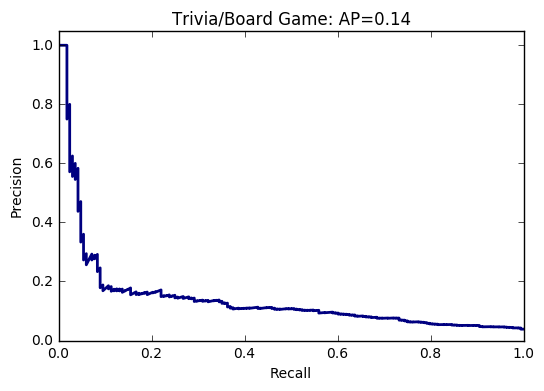

In [92]:
genre = 15
precision, recall, _ = precision_recall_curve(labels[:,genre], preds[:,genre])
ap = average_precision_score(labels[:,genre], preds[:,genre])

lw = 2
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(genres[genre] + ': AP={0:0.2f}'.format(ap))

In [49]:
def get_img(path):
    img = Image.open(path).convert('RGB')
    smaller = min(img.size[0], img.size[1])
    larger = max(img.size[0], img.size[1])
    pad_width = larger - smaller
    new_im = None
    if img.size[0] == smaller:
        new_size = (pad_width + img.size[0], img.size[1])
        new_im = Image.new("RGB", new_size)
        new_im.paste(img, (pad_width // 2, 0))
    else:
        new_size = (img.size[0], pad_width + img.size[1])
        new_im = Image.new("RGB", new_size)
        new_im.paste(img, (0, pad_width // 2))
    img = new_im
    im_trans = transforms.Compose([transforms.Scale(256),
        transforms.ToTensor()
    ])
    img = im_trans(img)
    return img

In [43]:
top_preds = np.zeros((16,5))
top_labels = np.zeros((16,5))
top_genres = np.zeros((16,5,16))
top_ids = np.zeros((16,5)).astype(int)
for genre, gid in genre_ids.items():
    order = np.argsort(preds[:,gid])[::-1]
    top_preds[gid] = preds[order[:5],gid]
    top_labels[gid] = labels[order[:5],gid]
    top_genres[gid] = labels[order[:5]]
    top_ids[gid] = np.copy(ids[order[:5]]).squeeze()

[49293 49520 52526 24382 23887]


In [9]:
img_tensor = get_img('scraped_imgs/' + str(top_ids[0][0]) + '.jpeg')

opened img
made new img
pasted img
about to transform


In [37]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

model = GenreClassifier(dtype, 16)
model.load_state_dict(pickle.load(open('models/genre_class_3bn_dropoutconv_ep_29.p', 'rb')))
model.eval()

GenreClassifier (
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (dropout): Dropout (p = 0.5)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin1): Linear (8192 -> 1024)
  (lin2): Linear (1024 -> 256)
  (lin3): Linear (256 -> 16)
)

In [153]:
for gid in range(16):
# for gid in range(4,5):
    path = 'scraped_imgs/'
    for i in range(5):
#     for i in range(3):
        img_tensor = get_img(path + str(top_ids[gid][i]) + '.jpeg').type(dtype)
        invar = V(img_tensor.unsqueeze(0), requires_grad=True)

        prediction = model(invar)

        loss = bce(prediction, V(torch.from_numpy(top_genres[gid][i])).type(dtype))
        loss.backward()

        grad_img = invar.grad.data.squeeze(0).cpu()
        mean = torch.mean(torch.max(grad_img, torch.zeros(grad_img.size())))
        pos_grad_img = F.threshold(V(torch.max(grad_img, torch.zeros(grad_img.size())) + mean), mean + mean * 0.1, 0).data / torch.max(grad_img)
        neg_grad_img = torch.max(-grad_img, torch.zeros(grad_img.size())) / -torch.min(grad_img)

        img = topil(img_tensor.squeeze(0).cpu())
#         img.show()
        img_name = 'img_grads/' + genres[gid] + '_'+ str(int(top_labels[gid][i])) + '_' + str(top_ids[gid][i])
        img.save(img_name + '.png')
        img_pos_grad = topil(pos_grad_img)
        img_pos_grad = img_pos_grad.filter(GaussianBlur(radius=1))
        img_pos_grad.save(img_name + '_grad.png')

#         img_pos_grad.show()
